# Smart Home Dataset with Weather Information

Group 2 : The Stormtroopers
1. Vandana Chandola	:	014748604
2. Nikhila Churia		:	014546116
3. Haasitha Pidaparthi	:	012669254


**Table Of Contents**
1. Data Pre-processing
2. Data Transformation
3. Data Visualization
4. Correlation between features
5. Time-Series Analysis
6. Anomaly Detection
7. Time-Series Forecasting

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 1 - Data Pre-processing

**Import CSV file from Google Drive.**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
home_df = pd.read_csv('/content/gdrive/Shared drives/CMPE 255 - Team Stormtroopers/sample_HomeC.csv')
home_df.head()

NameError: ignored

In [ ]:
home_df.tail(5)

,Unnamed: 0,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
49995,3783,1451628183,1.847850,0.018900,1.847850,0.000117,0.021567,0.662550,0.040117,0.005317,0.123433,0.013267,0.000767,0.047150,0.000017,0.029150,0.724750,0.004183,0.001517,0.018900,37.21,clear-night,0.56,10.00,Clear,31.40,1008.36,7.63,0.19,259.0,0.0000,23.00,0.00
49996,297240,1451921640,0.355383,0.351100,0.355383,0.000000,0.033667,0.067833,0.073933,0.123333,0.155250,0.012717,0.000583,0.000000,0.000000,0.029133,0.001000,0.004017,0.001583,0.351100,68.95,clear-night,0.81,9.85,Clear,68.95,1019.23,3.43,1,72.0,0.0044,62.80,0.18
49997,439108,1452063508,0.852833,0.003800,0.852833,0.000250,0.020783,0.063467,0.085033,0.100083,0.007933,0.013183,0.000517,0.000017,0.000000,0.032200,0.000783,0.003433,0.001317,0.003800,58.73,clear-day,0.29,10.00,Clear,58.73,1014.96,8.30,0,269.0,0.0000,26.64,0.00
49998,377121,1452001521,0.351017,0.004383,0.351017,0.000000,0.020117,0.065067,0.042700,0.005133,0.029317,0.012917,0.000783,0.000017,0.000017,0.032033,0.001017,0.003083,0.001533,0.004383,54.12,partly-cloudy-day,0.74,10.00,Partly Cloudy,54.12,1030.55,9.07,0.26,49.0,0.0000,46.17,0.00
49999,163265,1451787665,0.311900,0.086400,0.311900,0.000017,0.020183,0.066283,0.039233,0.005233,0.133233,0.012817,0.000733,0.000083,0.000017,0.030917,0.001000,0.004067,0.001833,0.086400,34.60,clear-day,0.91,6.66,Clear,32.05,1013.48,3.16,0,338.0,0.0000,32.23,0.00


**Remove the last row that contains invalid values.**

In [ ]:
#Removing the last row as it is invalid
home_df = home_df[0:-1]

In [ ]:
home_df.tail(5)

,Unnamed: 0,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
49994,151032,1451775432,0.667700,0.003600,0.667700,0.000017,0.020483,0.068583,0.041200,0.005200,0.007317,0.013100,0.000850,0.000033,0.000000,0.348667,0.001000,0.004300,0.001017,0.003600,74.53,clear-day,0.20,10.00,Clear,74.53,1021.56,3.95,0.04,312.0,0.0000,31.05,0.00
49995,3783,1451628183,1.847850,0.018900,1.847850,0.000117,0.021567,0.662550,0.040117,0.005317,0.123433,0.013267,0.000767,0.047150,0.000017,0.029150,0.724750,0.004183,0.001517,0.018900,37.21,clear-night,0.56,10.00,Clear,31.40,1008.36,7.63,0.19,259.0,0.0000,23.00,0.00
49996,297240,1451921640,0.355383,0.351100,0.355383,0.000000,0.033667,0.067833,0.073933,0.123333,0.155250,0.012717,0.000583,0.000000,0.000000,0.029133,0.001000,0.004017,0.001583,0.351100,68.95,clear-night,0.81,9.85,Clear,68.95,1019.23,3.43,1,72.0,0.0044,62.80,0.18
49997,439108,1452063508,0.852833,0.003800,0.852833,0.000250,0.020783,0.063467,0.085033,0.100083,0.007933,0.013183,0.000517,0.000017,0.000000,0.032200,0.000783,0.003433,0.001317,0.003800,58.73,clear-day,0.29,10.00,Clear,58.73,1014.96,8.30,0,269.0,0.0000,26.64,0.00
49998,377121,1452001521,0.351017,0.004383,0.351017,0.000000,0.020117,0.065067,0.042700,0.005133,0.029317,0.012917,0.000783,0.000017,0.000017,0.032033,0.001017,0.003083,0.001533,0.004383,54.12,partly-cloudy-day,0.74,10.00,Partly Cloudy,54.12,1030.55,9.07,0.26,49.0,0.0000,46.17,0.00


**The column names contain the unit value in the title. Remove the [kW] the columns.**

In [ ]:
#Removing [kW] from column names
home_df.columns = [col.replace(' [kW]', '') for col in home_df.columns]
home_df.columns

Index(['Unnamed: 0', 'time', 'use', 'gen', 'House overall', 'Dishwasher',
       'Furnace 1', 'Furnace 2', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well',
       'Microwave', 'Living room', 'Solar', 'temperature', 'icon', 'humidity',
       'visibility', 'summary', 'apparentTemperature', 'pressure', 'windSpeed',
       'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability'],
      dtype='object')

In [ ]:
home_df.head()

,Unnamed: 0,time,use,gen,House overall,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,Kitchen 12,Kitchen 14,Kitchen 38,Barn,Well,Microwave,Living room,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,174471,1451798871,0.478517,0.003033,0.478517,0.000000,0.020450,0.063867,0.042000,0.127650,0.006750,0.013033,0.000383,0.000083,0.000000,0.033183,0.001000,0.004000,0.001633,0.003033,46.79,clear-day,0.80,9.40,Clear,41.87,1007.81,10.52,1.0,34.0,0.0,40.86,0.0
1,42966,1451667366,0.735833,0.003067,0.735833,0.000067,0.201483,0.063983,0.064250,0.004967,0.007367,0.012600,0.000783,0.000100,0.000017,0.030383,0.000983,0.004000,0.001767,0.003067,41.53,clear-night,0.60,10.00,Clear,37.15,1009.58,6.71,0.04,187.0,0.0,28.58,0.0
2,444242,1452068642,0.032133,0.387300,0.032133,0.000283,0.020300,0.065867,0.039583,0.005117,0.008033,0.012983,0.000667,0.000017,0.000000,0.029650,0.001000,0.003217,0.001533,0.387300,45.57,clear-day,0.83,8.35,Clear,41.29,1015.29,8.18,0.06,315.0,0.0,40.67,0.0
3,199629,1451824029,0.229717,0.280433,0.229717,0.000000,0.020283,0.068033,0.111367,0.005000,0.126250,0.012900,0.000733,0.000083,0.000000,0.032017,0.001000,0.004033,0.001450,0.280433,67.46,clear-day,0.59,10.00,Clear,67.46,1013.78,5.25,0.04,11.0,0.0,52.56,0.0
4,213860,1451838260,0.022133,0.409583,0.022133,0.000000,0.020150,0.069067,0.027350,0.005050,0.128483,0.012800,0.000750,0.000067,0.000000,0.028567,0.000983,0.004000,0.000983,0.409583,78.23,clear-day,0.47,10.00,Clear,78.23,1018.71,8.55,0.11,168.0,0.0,56.13,0.0


**There are multiple columns of similar rooms in the dataset. For example, there is 'Furnace 1' and 'Furnace 2'. We can remove the additional columns by summing them.**

In [ ]:
#Summing the columns 'Furnace 1' and 'Furnace 2' since we only need the total energy usage by both the furnaces
home_df['Furnace'] = home_df[['Furnace 1','Furnace 2']].sum(axis=1)


In [ ]:
#Finding the average usage of all kitchens('Kitchen 12','Kitchen 14','Kitchen 38')
home_df['Kitchen'] = home_df[['Kitchen 12','Kitchen 14','Kitchen 38']].mean(axis=1)

In [ ]:
#Dropping old columns on which the aggregation have been done
home_df = home_df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)

In [ ]:

home_df.head()

,Unnamed: 0,time,use,gen,House overall,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
0,174471,1451798871,0.478517,0.003033,0.478517,0.000000,0.042000,0.127650,0.006750,0.013033,0.033183,0.001000,0.004000,0.001633,0.003033,46.79,clear-day,0.80,9.40,Clear,41.87,1007.81,10.52,1.0,34.0,0.0,40.86,0.0,0.084317,0.000156
1,42966,1451667366,0.735833,0.003067,0.735833,0.000067,0.064250,0.004967,0.007367,0.012600,0.030383,0.000983,0.004000,0.001767,0.003067,41.53,clear-night,0.60,10.00,Clear,37.15,1009.58,6.71,0.04,187.0,0.0,28.58,0.0,0.265467,0.000300
2,444242,1452068642,0.032133,0.387300,0.032133,0.000283,0.039583,0.005117,0.008033,0.012983,0.029650,0.001000,0.003217,0.001533,0.387300,45.57,clear-day,0.83,8.35,Clear,41.29,1015.29,8.18,0.06,315.0,0.0,40.67,0.0,0.086167,0.000228
3,199629,1451824029,0.229717,0.280433,0.229717,0.000000,0.111367,0.005000,0.126250,0.012900,0.032017,0.001000,0.004033,0.001450,0.280433,67.46,clear-day,0.59,10.00,Clear,67.46,1013.78,5.25,0.04,11.0,0.0,52.56,0.0,0.088317,0.000272
4,213860,1451838260,0.022133,0.409583,0.022133,0.000000,0.027350,0.005050,0.128483,0.012800,0.028567,0.000983,0.004000,0.000983,0.409583,78.23,clear-day,0.47,10.00,Clear,78.23,1018.71,8.55,0.11,168.0,0.0,56.13,0.0,0.089217,0.000272


**The column 'time' is in unix timestamp. Convert the timestamp to date and time.**

In [ ]:

#Finding the start time
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(home_df['time'].iloc[0]))))


 start  2016-01-03 05:27:51


In [ ]:
#Converting the unix timestamp values in the column 'time' to a readable date format
#Setting freq= 'min' since readings are being taken in a time span of one min
time_index = pd.date_range('2016-01-01 05:00', periods=len(home_df),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
home_df = home_df.set_index(time_index)
home_df = home_df.drop(['time'], axis=1)
home_df.iloc[np.r_[0:5,-5:0]].iloc[:,0]

2016-01-01 05:00:00    174471
2016-01-01 05:01:00     42966
2016-01-01 05:02:00    444242
2016-01-01 05:03:00    199629
2016-01-01 05:04:00    213860
2016-02-04 22:14:00    151032
2016-02-04 22:15:00      3783
2016-02-04 22:16:00    297240
2016-02-04 22:17:00    439108
2016-02-04 22:18:00    377121
Name: Unnamed: 0, dtype: int64

**Examine the data type of each column.**

In [ ]:
#Display dataframe info
home_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49999 entries, 2016-01-01 05:00:00 to 2016-02-04 22:18:00
Freq: T
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           49999 non-null  int64  
 1   use                  49999 non-null  float64
 2   gen                  49999 non-null  float64
 3   House overall        49999 non-null  float64
 4   Dishwasher           49999 non-null  float64
 5   Home office          49999 non-null  float64
 6   Fridge               49999 non-null  float64
 7   Wine cellar          49999 non-null  float64
 8   Garage door          49999 non-null  float64
 9   Barn                 49999 non-null  float64
 10  Well                 49999 non-null  float64
 11  Microwave            49999 non-null  float64
 12  Living room          49999 non-null  float64
 13  Solar                49999 non-null  float64
 14  temperature          49999 non-null  float6

In [ ]:
#Drop columns 'icon' and 'summary' as their data type is 'object'
home_df = home_df.drop(['icon', 'summary'], axis=1)

In [ ]:
#Examining the unique values of the attribute 'cloudCover' to see if there is any invalid data that needs to be handled
home_df['cloudCover'].unique()

array(['1.0', '0.04', '0.06', '0.11', '0.31', '0.09', '0.2', '0.21',
       '0.14', '0.0', '0.16', '0.03', '0.1', '0', '0.08', '0.19', '0.25',
       '0.78', '0.26', '0.27', '0.44', '0.75', '0.13', '0.24', '0.22',
       '0.12', '0.05', '0.02', '0.23', '0.17', '0.07', '0.28', '0.76',
       '0.29', '0.18', '0.01', '0.15', '0.35', '0.5', '0.45', '0.43',
       '0.36', '0.38', '1', '0.47', '0.77', '0.62', '0.37', '0.41',
       '0.49', '0.6', '0.52', '0.46', '0.63', '0.56', '0.51', '0.42',
       '0.55', '0.61', '0.3', '0.32', '0.34', '0.66', '0.68', '0.33',
       '0.4', '0.54', '0.39', '0.48', '0.58', '0.71', '0.57', '0.67',
       '0.79', '0.73', '0.64', '0.53', '0.72', 'cloudCover', '0.59', 1.0,
       0.31, 0.26, 0.15, 0.07, 0.1, 0.03, 0.24, 0.21, 0.0, 0.02, 0.13,
       0.04, 0.05, 0.09, 0.16, 0.12, 0.11, 0.08, 0.19, 0.17, 0.14, 0.52,
       0.27, 0.06, 0.23, 0.25, 0.35, 0.22, 0.2, 0.75, 0.01, 0.18, 0.29,
       0.61, 0.66, 0.3, 0.46, 0.45, 0.72, 0.28, 0.41, 0.43, 0.55, 0.78,
     

In [ ]:
#We see that for some rows we have an invalid value for cloudCover.
home_df[home_df['cloudCover'] == 'cloudCover'].shape

(4, 27)

In [ ]:
#We replace these missing values with the next valid observation we have
home_df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
home_df['cloudCover'] = home_df['cloudCover'].astype('float')

In [ ]:
#It seems use and House overall show the same data
home_df[['use', 'House overall']].head()

,use,House overall
2016-01-01 05:00:00,0.478517,0.478517
2016-01-01 05:01:00,0.735833,0.735833
2016-01-01 05:02:00,0.032133,0.032133
2016-01-01 05:03:00,0.229717,0.229717
2016-01-01 05:04:00,0.022133,0.022133


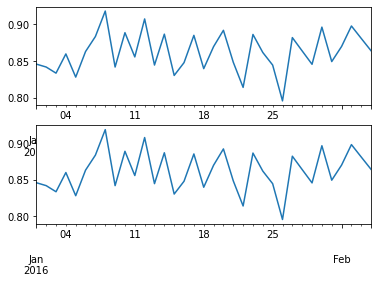

In [ ]:
# Let's visualize these use and House overall to confirm they show the same data so that we could remove one of the columns
fig, axes = plt.subplots(nrows=2, ncols=1)
home_df['use'].resample('D').mean().plot(ax=axes[0])
home_df['House overall'].resample('D').mean().plot(ax=axes[1])

In [ ]:
#Since the above plot confirms both the columns indicate the same data lets go ahead and remove 'House overall'
home_df = home_df.drop(columns=['House overall'])
home_df.shape

(49999, 26)

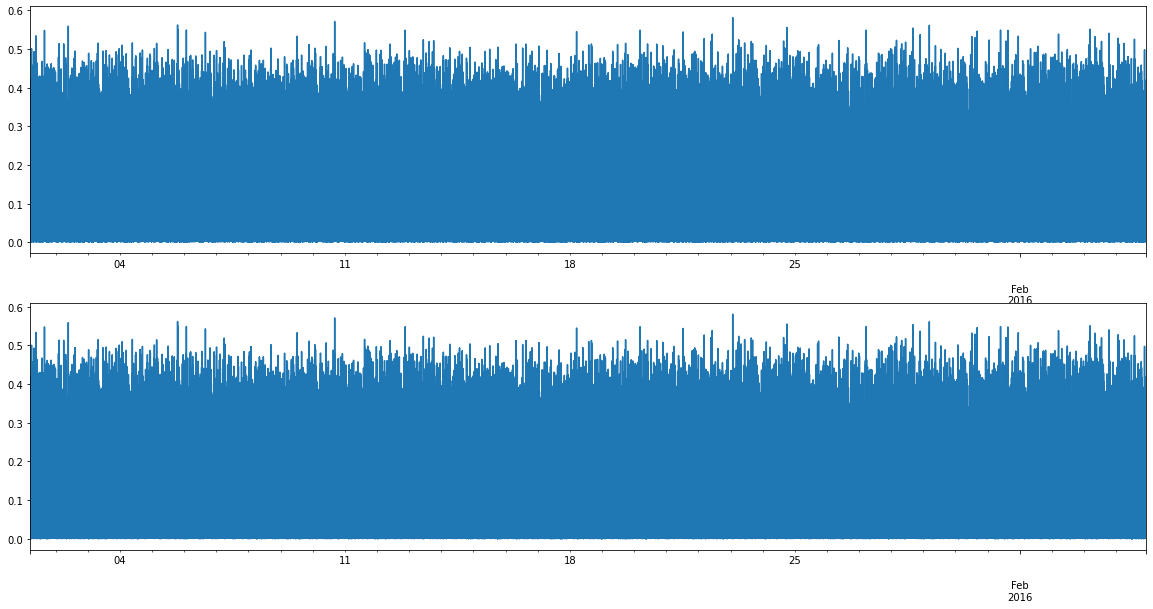

In [ ]:
#Similarly, the attributes 'gen' and 'Solar' show the same data. Let's visualize these two columns to confirm the same
fig, axes = plt.subplots(nrows=2, ncols=1)
home_df['gen'].plot(ax=axes[0],figsize=(20,10))
home_df['Solar'].plot(ax=axes[1],figsize=(20,10))

In [ ]:
#Dropping the column 'Solar' since it shows the same data as 'gen'
home_df = home_df.drop(columns=['Solar'])
home_df.shape

(49999, 25)

## Part 2 - Data Transformation

In [ ]:

#Creating two separate dataframe objects with energy and weather data respectively.
energy_data = home_df.filter(items=[ 'gen', 'use', 'Dishwasher',
                                     'Furnace', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen', 'Barn', 'Well',
                                     'Microwave', 'Living room'])

weather_data = home_df.filter(items=['temperature',
                                      'humidity', 'visibility', 'apparentTemperature', 'pressure',
                                      'windSpeed', 'windBearing', 'dewPoint'])

In [ ]:
energy_data.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-01 05:00:00,0.003033,0.478517,0.000000,0.084317,0.042000,0.127650,0.006750,0.013033,0.000156,0.033183,0.001000,0.004000,0.001633
2016-01-01 05:01:00,0.003067,0.735833,0.000067,0.265467,0.064250,0.004967,0.007367,0.012600,0.000300,0.030383,0.000983,0.004000,0.001767
2016-01-01 05:02:00,0.387300,0.032133,0.000283,0.086167,0.039583,0.005117,0.008033,0.012983,0.000228,0.029650,0.001000,0.003217,0.001533
2016-01-01 05:03:00,0.280433,0.229717,0.000000,0.088317,0.111367,0.005000,0.126250,0.012900,0.000272,0.032017,0.001000,0.004033,0.001450
2016-01-01 05:04:00,0.409583,0.022133,0.000000,0.089217,0.027350,0.005050,0.128483,0.012800,0.000272,0.028567,0.000983,0.004000,0.000983


In [ ]:
weather_data.head()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,dewPoint
2016-01-01 05:00:00,46.79,0.80,9.40,41.87,1007.81,10.52,34.0,40.86
2016-01-01 05:01:00,41.53,0.60,10.00,37.15,1009.58,6.71,187.0,28.58
2016-01-01 05:02:00,45.57,0.83,8.35,41.29,1015.29,8.18,315.0,40.67
2016-01-01 05:03:00,67.46,0.59,10.00,67.46,1013.78,5.25,11.0,52.56
2016-01-01 05:04:00,78.23,0.47,10.00,78.23,1018.71,8.55,168.0,56.13


In [ ]:
#Generating the data per day
energy_per_day = energy_data.resample('D').sum()
energy_per_day.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-01,93.739450,964.110017,31.507189,262.777383,89.357483,68.976250,47.479383,16.022617,3.324400,75.975317,11.970417,14.364917,35.043550
2016-01-02,110.368583,1212.072167,43.424275,331.867367,115.301867,93.286883,58.159483,20.344017,7.747808,80.318600,18.967000,13.060200,49.844367
2016-01-03,106.970133,1200.051600,35.538426,346.633000,115.242667,88.896217,59.675083,19.601150,3.286513,94.702717,18.127933,11.598267,46.963150
2016-01-04,109.579067,1237.830050,51.786058,341.394400,121.579483,91.272917,60.619250,20.843417,3.383318,79.081033,17.543267,23.142933,55.392367
2016-01-05,116.496617,1192.251017,41.485159,325.691167,120.095800,88.575833,62.061250,20.365217,6.967213,82.598017,18.597700,23.230633,50.653983


In [ ]:
#Generating the data per week
energy_per_week = energy_data.resample('W').sum()
energy_per_week.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-03,311.078167,3376.233783,110.469891,941.277750,319.902017,251.159350,165.313950,55.967783,14.358721,250.996633,49.065350,39.023383,131.851067
2016-01-10,783.260817,8758.604383,328.671297,2361.018000,839.398350,631.338600,427.894483,142.063317,35.258885,595.544200,136.931383,130.433033,358.927883
2016-01-17,754.365667,8721.878717,288.814246,2374.179133,807.895283,652.642583,428.496867,141.445650,35.262287,590.345467,187.670350,118.321000,366.582083
2016-01-24,784.565567,8655.709817,310.155432,2367.332850,818.030900,641.721800,426.133033,143.413000,36.840460,597.829900,174.516817,115.101550,366.362200
2016-01-31,756.925200,8605.770533,297.801196,2388.513984,815.624100,645.167900,437.325850,142.991117,34.531643,605.820383,154.959367,103.791883,359.770017


In [ ]:
#Generating the data per month
energy_per_month = energy_data.resample('M').sum() 
energy_per_month.head()

,gen,use,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room
2016-01-31,3390.195417,38118.197233,1335.912063,10432.321717,3600.85065,2822.030233,1885.164184,625.880867,156.251997,2640.536583,703.143267,506.670850,1583.49325
2016-02-29,422.686817,4970.202467,174.527236,1374.092800,464.73365,357.563917,234.811267,79.551717,15.067030,331.888200,89.821883,62.852033,192.28120


## Part 3 - Data Visualization

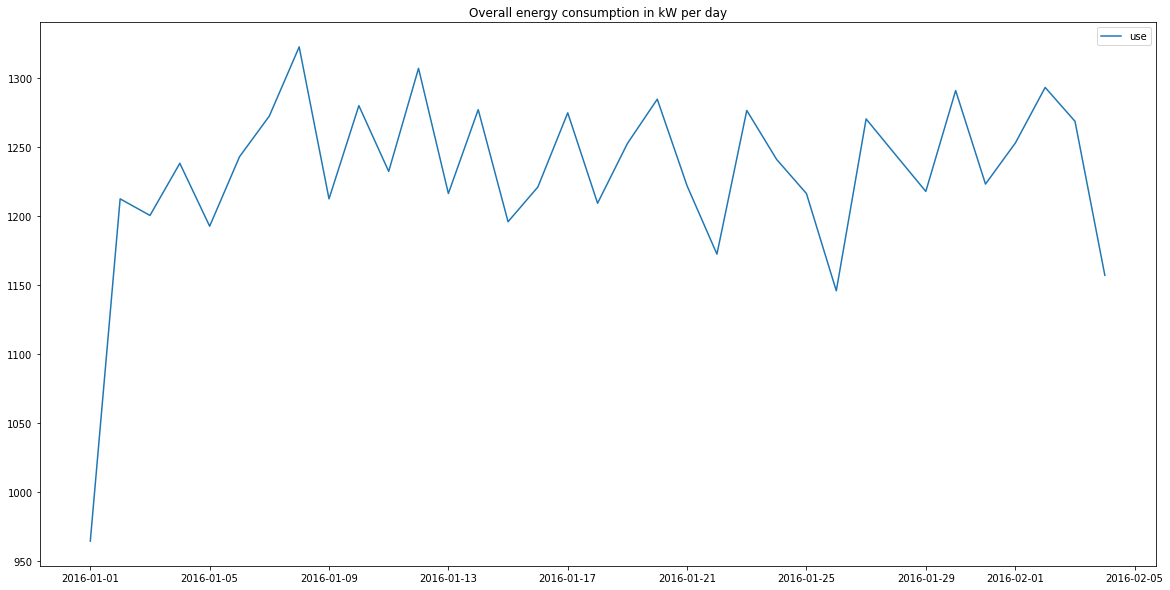

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Overall energy consumption in kW per day")
#Plotting the energy consumption per day
sns.lineplot(data = energy_per_day.filter(items=['use']), dashes=False)

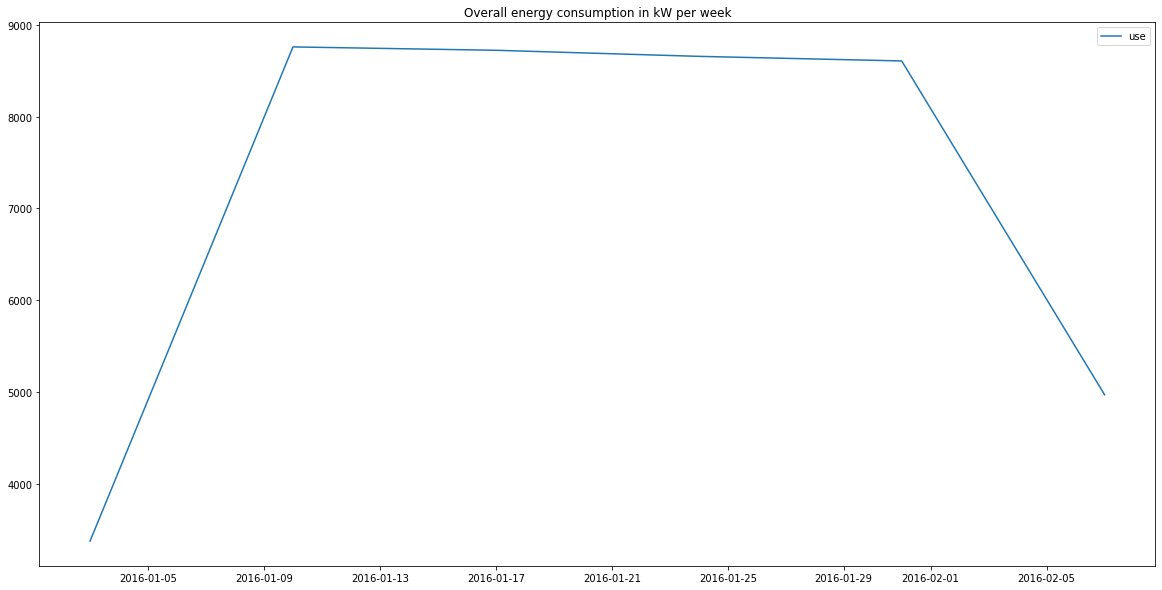

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Overall energy consumption in kW per week")
#Plotting the energy consumption per week
sns.lineplot(data = energy_per_week.filter(items=['use']), dashes=False)

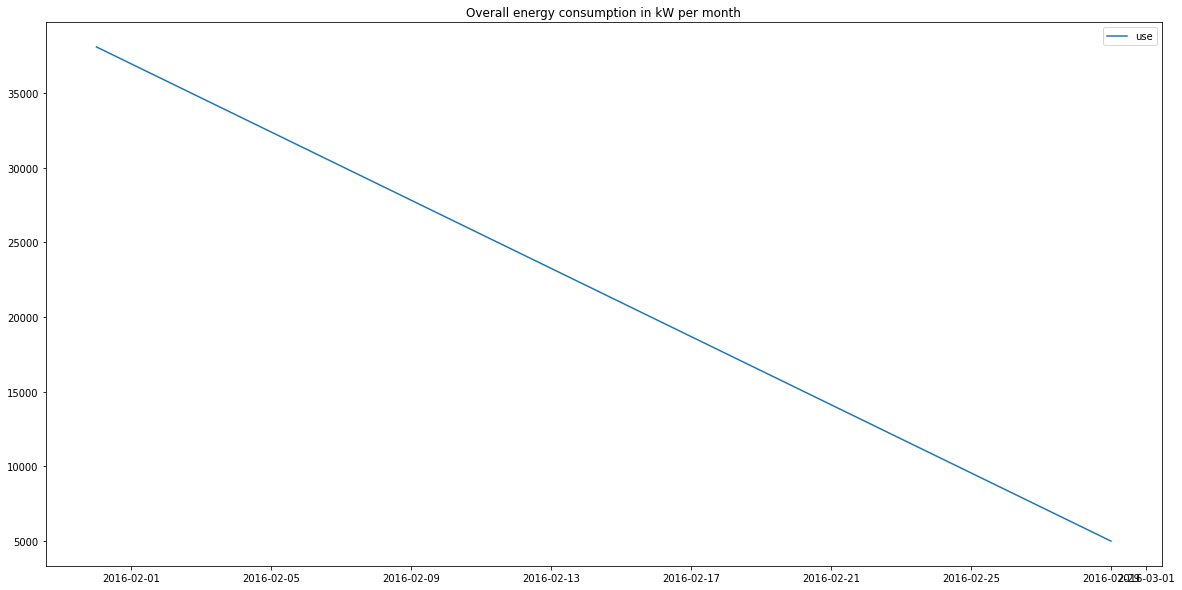

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Overall energy consumption in kW per month")
#Plotting the energy consumption per month
sns.lineplot(data = energy_per_month.filter(items=['use']), dashes=False)

**August and September are the months with the highest energy consumption as per the above plot**

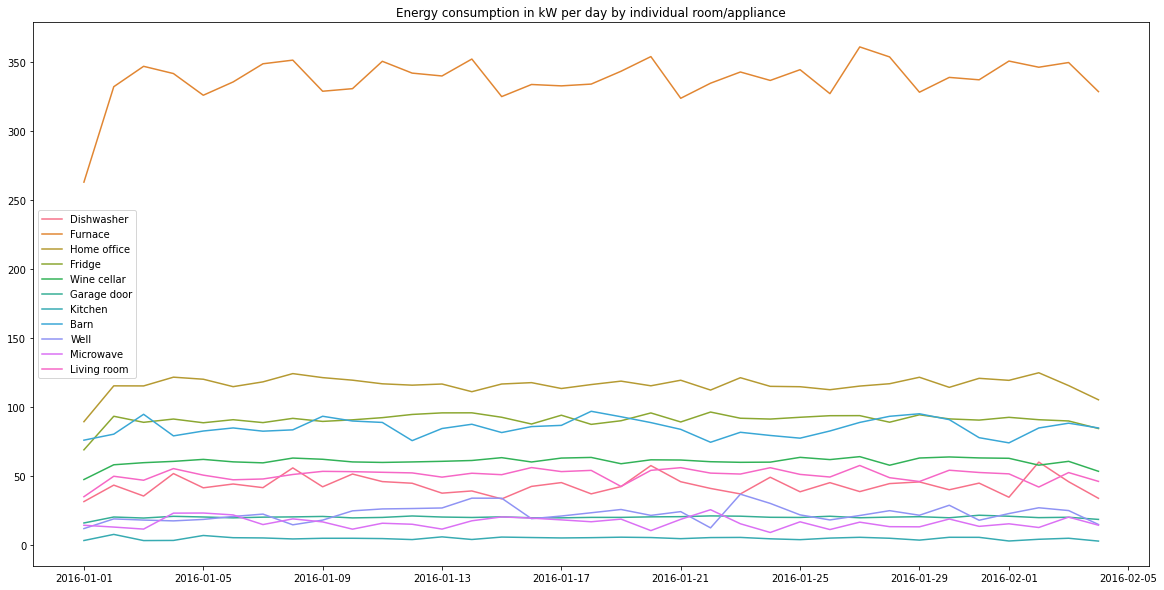

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Energy consumption in kW per day by individual room/appliance")
sns.lineplot(data = energy_per_day.filter(items=['Dishwasher',
                                     'Furnace', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen', 'Barn', 'Well',
                                     'Microwave', 'Living room']), dashes=False)

**The above plot indicates that furnace has the highest energy consumption among the rooms/devices in the smart home in a day**

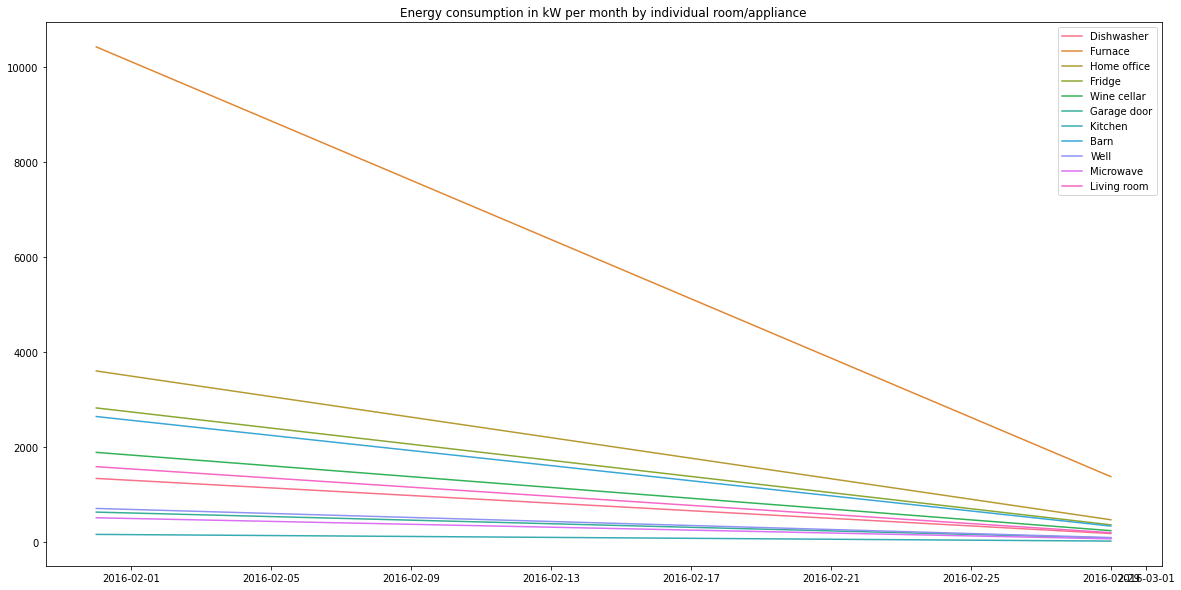

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Energy consumption in kW per month by individual room/appliance")
sns.lineplot(data = energy_per_month.filter(items=['Dishwasher',
                                     'Furnace', 'Home office', 'Fridge',
                                     'Wine cellar', 'Garage door', 'Kitchen', 'Barn', 'Well',
                                     'Microwave', 'Living room']), dashes=False)

**The above plot indicates that furnace has the highest energy consumption among the rooms/devices and Kitchen has the lowest in the smart home in a month.**

In [ ]:
#Below we are splitting the energy consumption per month data into two sets. 

#1) Energy consumed by each room in the house
energy_per_room = energy_per_month.filter(items=['Home office',
                                     'Wine cellar', 'Kitchen','Barn',
                                      'Living room']) 

#2) Energy consumed by each device in the house
energy_per_device = energy_per_month.filter(items=[ 'Dishwasher',
                                     'Furnace','Fridge',
                                     'Garage door', 'Well',
                                     'Microwave'])

rooms_energy_consumption = energy_per_room.sum()
devices_energy_consumption = energy_per_device.sum()
print("Energy consumed in kW per month by each room in the house")
print(rooms_energy_consumption)
print("Energy consumed in kW per month by each device in the house")
print(devices_energy_consumption)

Energy consumed in kW per month by each room in the house
Home office    4065.584299
Wine cellar    2119.975451
Kitchen         171.319027
Barn           2972.424783
Living room    1775.774450
dtype: float64
Energy consumed in kW per month by each device in the house
Dishwasher      1510.439299
Furnace        11806.414517
Fridge          3179.594150
Garage door      705.432583
Well             792.965150
Microwave        569.522883
dtype: float64


****

Text(0.5, 1.0, 'Energy consumption in kW by each room in the house')

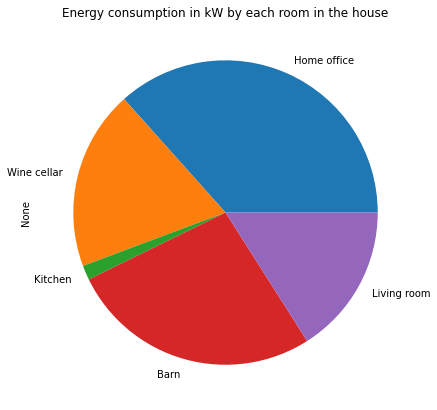

In [ ]:
plot = rooms_energy_consumption .plot(kind = "pie", figsize = (7,7))
plot.set_title("Energy consumption in kW by each room in the house")

**Home office has the highest energy consumption and kitchen the lowest among all the rooms in the house.**

Text(0.5, 1.0, 'Energy consumption in kW by each device in the house')

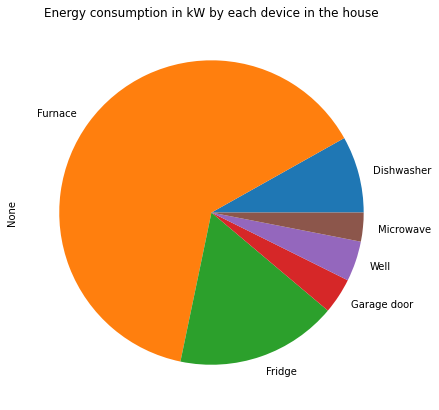

In [ ]:
plot = devices_energy_consumption .plot(kind = "pie", figsize = (7,7))
plot.set_title("Energy consumption in kW by each device in the house")

**Furnace has the highest energy consumption and Microwave has the lowest among all the devices in the house.**

## Part 4 - Correlation between features

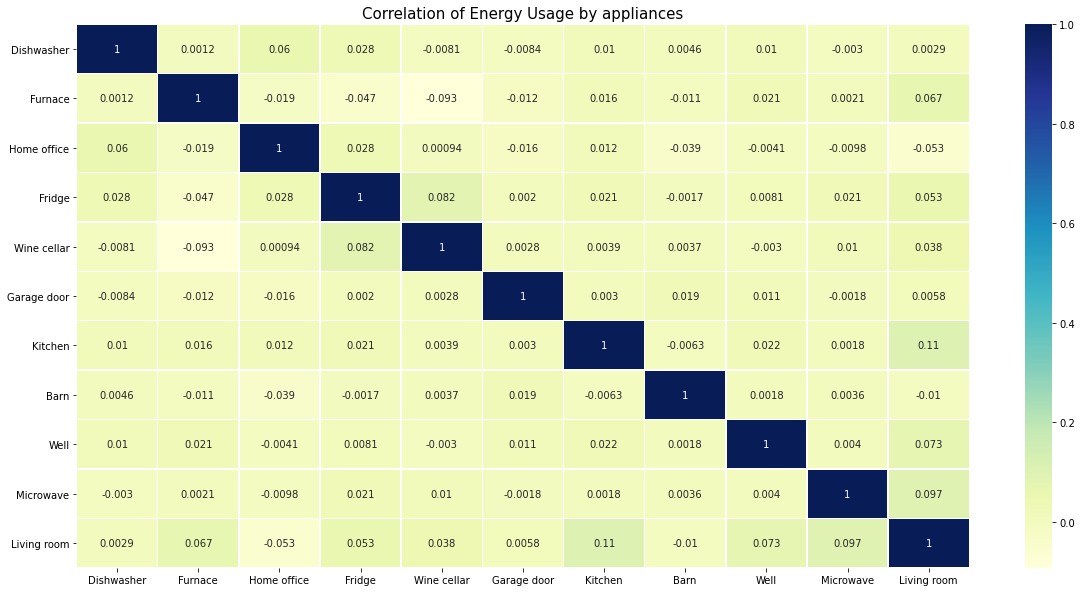

In [ ]:
#Correlation of energy usage by home appliances

energy_corr = energy_data.loc[:,'Dishwasher':].corr()
fig,ax = plt.subplots(figsize=(20, 10)) 
sns.heatmap(energy_corr, linewidths=0.5, annot=True, cmap="YlGnBu");
ax.set_title("Correlation of Energy Usage by appliances", size=15)
plt.show()

**No significant relationship between features, positive or negative, was observed. It is safe to presume that there is no interdependency between appliances when it comes to energy consumption.**

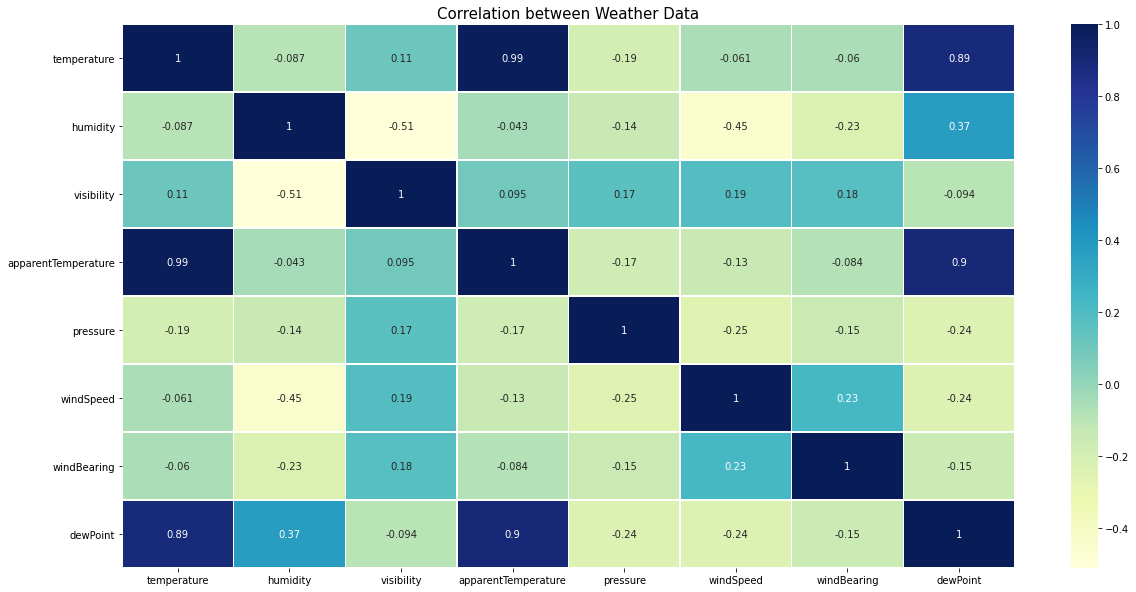

In [ ]:
#Correlation between weather data

weather_corr = weather_data.corr()
fig,ax = plt.subplots(figsize=(20, 10)) 
sns.heatmap(weather_corr, linewidths=0.5, annot=True, cmap="YlGnBu");
ax.set_title("Correlation between Weather Data", size=15)
plt.show()

**Strong positive correlation is observed here between some weather features:** 
**1. temperature and apparentTemperature (0.99)**
**2. temperature and dewPoint (0.89)**
**3. apparentTemperature and dewPoint (0.9)**

In [ ]:
# Merge energy and weather datasets
allData_df = pd.merge(energy_data.loc[:,'Dishwasher':], weather_data, left_index=True, right_index=True)
allData_df.head()

,Dishwasher,Furnace,Home office,Fridge,Wine cellar,Garage door,Kitchen,Barn,Well,Microwave,Living room,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,dewPoint
2016-01-01 05:00:00,0.000000,0.084317,0.042000,0.127650,0.006750,0.013033,0.000156,0.033183,0.001000,0.004000,0.001633,46.79,0.80,9.40,41.87,1007.81,10.52,34.0,40.86
2016-01-01 05:01:00,0.000067,0.265467,0.064250,0.004967,0.007367,0.012600,0.000300,0.030383,0.000983,0.004000,0.001767,41.53,0.60,10.00,37.15,1009.58,6.71,187.0,28.58
2016-01-01 05:02:00,0.000283,0.086167,0.039583,0.005117,0.008033,0.012983,0.000228,0.029650,0.001000,0.003217,0.001533,45.57,0.83,8.35,41.29,1015.29,8.18,315.0,40.67
2016-01-01 05:03:00,0.000000,0.088317,0.111367,0.005000,0.126250,0.012900,0.000272,0.032017,0.001000,0.004033,0.001450,67.46,0.59,10.00,67.46,1013.78,5.25,11.0,52.56
2016-01-01 05:04:00,0.000000,0.089217,0.027350,0.005050,0.128483,0.012800,0.000272,0.028567,0.000983,0.004000,0.000983,78.23,0.47,10.00,78.23,1018.71,8.55,168.0,56.13


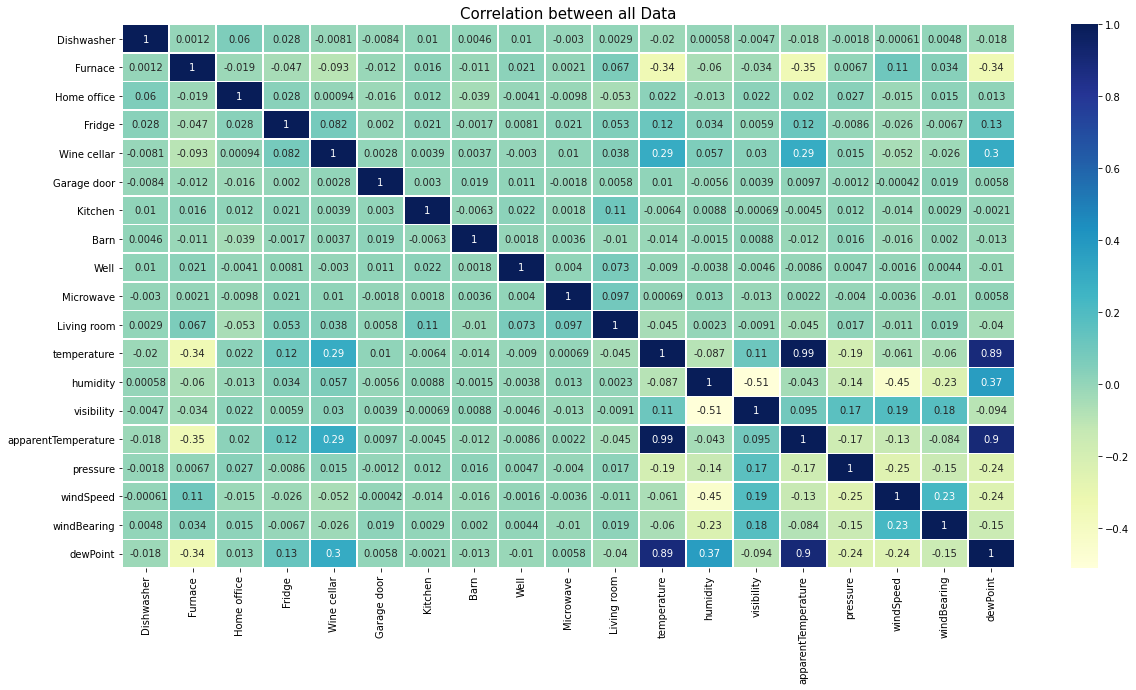

In [ ]:
#Correlation between all data

all_corr = allData_df.corr()
fig,ax = plt.subplots(figsize=(20, 10)) 
sns.heatmap(all_corr, linewidths=0.5, annot=True, cmap="YlGnBu");
ax.set_title("Correlation between all Data", size=15)
plt.show()

**Weak correlation between wine cellar and weather features like dewPoint(0.3), apparentTemperature(0.29) and temperature(0.29).
Relationships observed between other features as well, but not as significant.**

## Part 5 - Time Series Analysis

In [ ]:
# define function to convert hour to time of day

def convertHourToPartOfDay(x):
    if x in [22,23,0,1,2,3]:
        part = 'Night'
    elif x in range(4, 12):
        part = 'Morning'
    elif x in range(12, 17):
        part = 'Afternoon'
    elif x in range(17, 22):
        part = 'Evening'
    else:
        part = 'X'
    return part

In [ ]:
# define function to group by time of day

def groupByPartOfDay(column):
    partOfDayDf = energy_per_part_of_day.groupby('part').agg({column:['mean']})
    partOfDayDf.columns = [f"{i[0]}_{i[1]}" for i in partOfDayDf.columns]
    partOfDayDf['part_num'] = [['Morning','Afternoon','Evening','Night'].index(i) for i in partOfDayDf.index]
    partOfDayDf.sort_values('part_num', inplace=True)
    partOfDayDf.drop('part_num', axis=1, inplace=True)
    return partOfDayDf

In [ ]:
# create column to indicate time of day in dataset

energy_per_part_of_day = energy_data.loc[:]
energy_per_part_of_day['hour'] = energy_per_part_of_day.index.map(lambda x: x.hour)
energy_per_part_of_day['part'] = energy_per_part_of_day['hour'].apply(convertHourToPartOfDay)

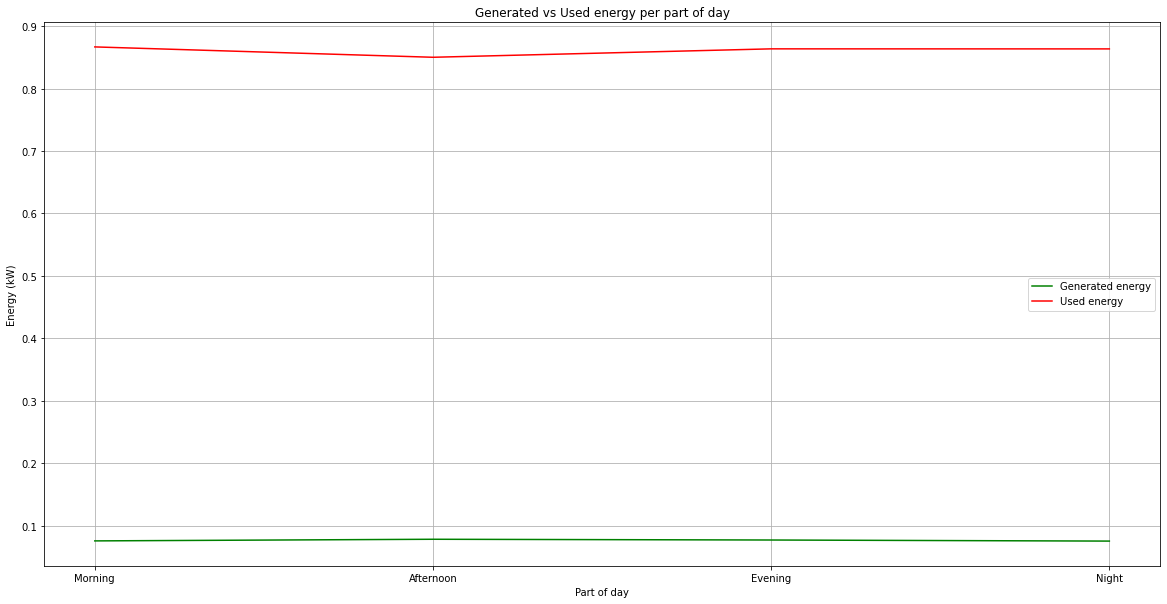

In [ ]:
# Plot generated vs used energy per part of day

plt.figure(figsize=(20,10))
plt.plot(groupByPartOfDay('gen'), 'g', label='Generated energy')
plt.plot(groupByPartOfDay('use'), 'r', label='Used energy')
plt.title('Generated vs Used energy per part of day')
plt.ylabel('Energy (kW)')
plt.xlabel('Part of day')
plt.legend()
plt.grid(True)
plt.show()

**Highest energy usage is observed during evening and night. The energy generation is relatively higher during afternoon and evening.**

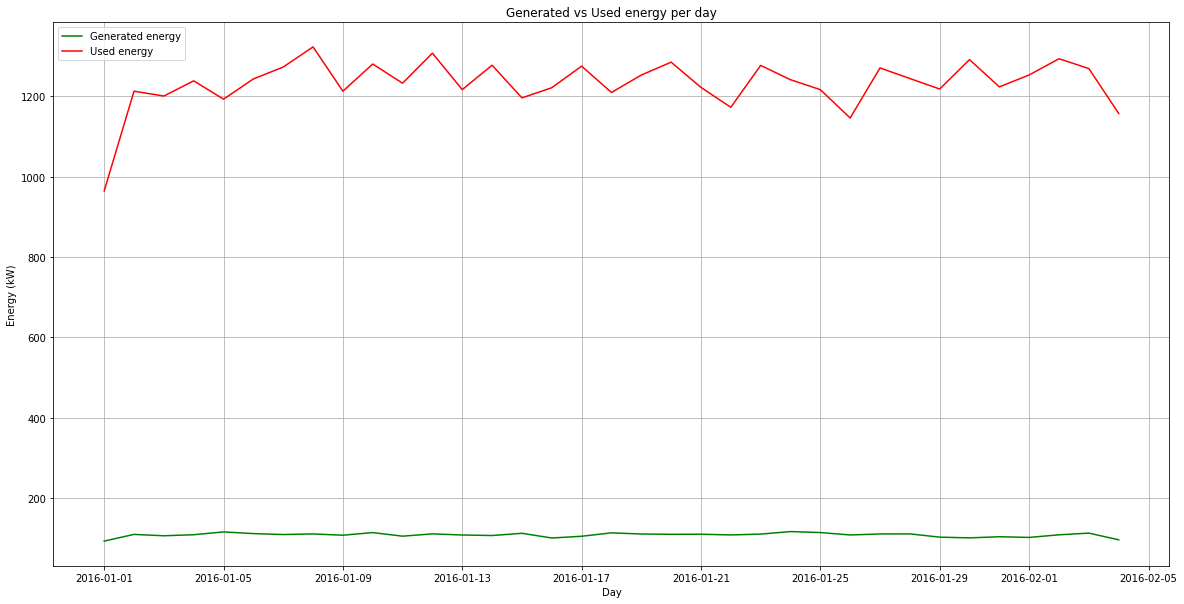

In [ ]:
# Plot generated vs used energy per day

plt.figure(figsize=(20,10))
plt.plot(energy_per_day.gen, 'g', label='Generated energy')
plt.plot(energy_per_day.use, 'r', label='Used energy')
plt.title('Generated vs Used energy per day')
plt.ylabel('Energy (kW)')
plt.xlabel('Day')
plt.legend()
plt.grid(True)
plt.show()

**Highest energy usage is observed in the days between July and September. The energy generation is mostly consistent throughtout the year.**

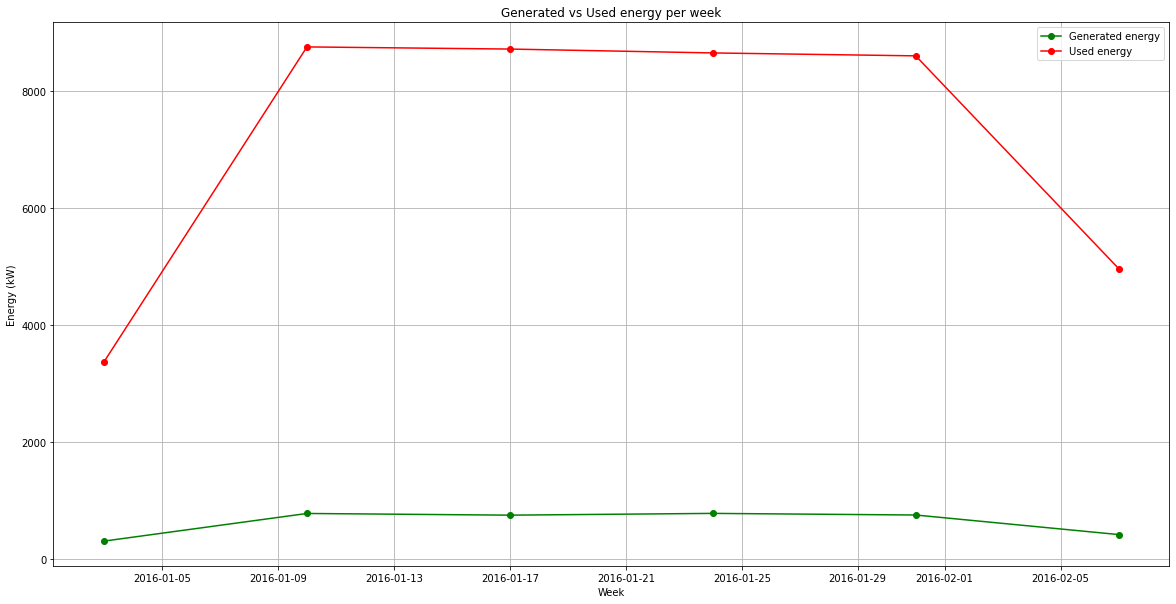

In [ ]:
# Plot generated vs used energy per week

plt.figure(figsize=(20,10))
plt.plot(energy_per_week.gen, 'go-', label='Generated energy')
plt.plot(energy_per_week.use, 'ro-', label='Used energy')
plt.title('Generated vs Used energy per week')
plt.ylabel('Energy (kW)')
plt.xlabel('Week')
plt.grid(True)
plt.legend()
plt.show()

**Highest energy usage is observed in the weeks between July and September. The energy generation is slightly high in the weeks between April and May but mostly consistent.**

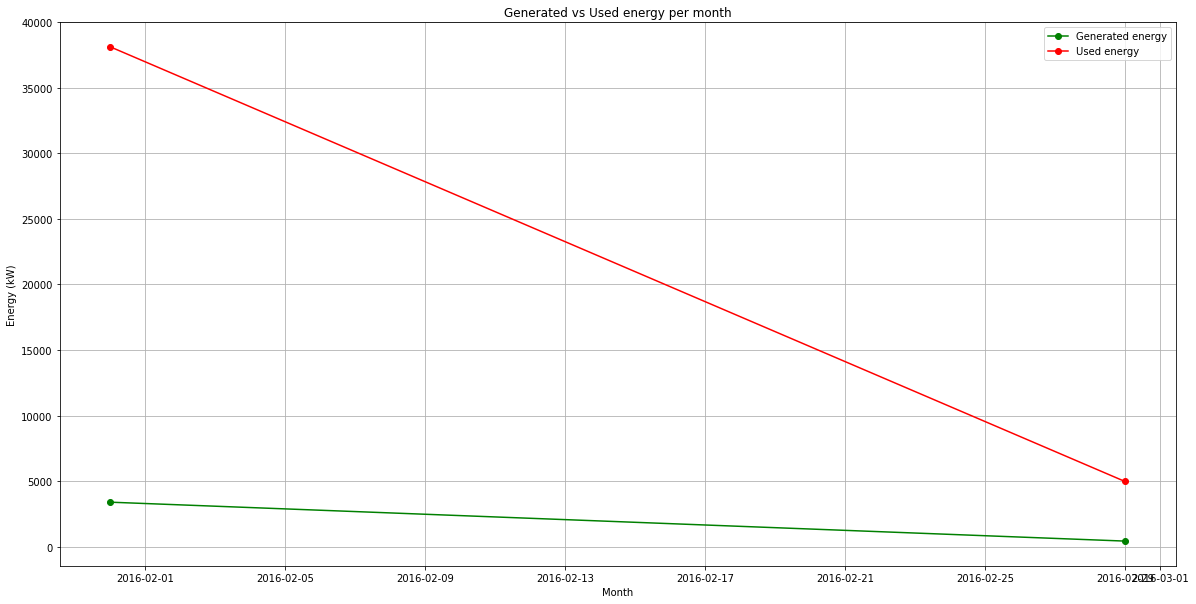

In [ ]:
# Plot generated vs used energy per month

plt.figure(figsize=(20,10))
plt.plot(energy_per_month.gen, 'go-', label='Generated energy')
plt.plot(energy_per_month.use, 'ro-', label='Used energy')
plt.title('Generated vs Used energy per month')
plt.ylabel('Energy (kW)')
plt.xlabel('Month')
plt.grid(True)
plt.legend()
plt.show()

**Highest energy usage is observed in the month of September. Months like August, February, March, April and December show high usage as well. The energy generation is slightly high in the month of July but mostly consistent.**

## 3 main factors of Time-Series Analysis:
### 1. Autocorrelation
### 2. Seasonality
### 3. Stationarity

**1. Autocorrelation**

Autocorrelation for 'gen' =  0.0937610012345385


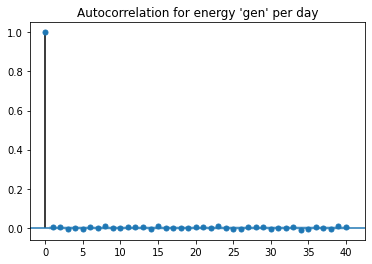

In [ ]:
#Plot ACF for energy 'gen'

print("Autocorrelation for 'gen' = ", energy_per_day['gen'].autocorr())
fig = plot_acf(energy_data['gen'], lags=40, title="Autocorrelation for energy 'gen' per day")
plt.show()

**Data has positive autocorrelation. It provides good predictability with autocorrelation value = 0.41.**

Autocorrelation for 'use' =  -0.031259276879052805


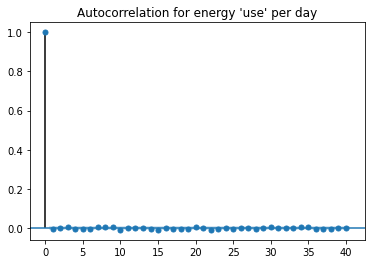

In [ ]:
#Plot ACF for energy 'use'

print("Autocorrelation for 'use' = ", energy_per_day['use'].autocorr())
fig = plot_acf(energy_data['use'], lags=40, title="Autocorrelation for energy 'use' per day")
plt.show()

**Data has positive autocorrelation. It provides good predictability with autocorrelation value = 0.61.**

**2. Seasonality**

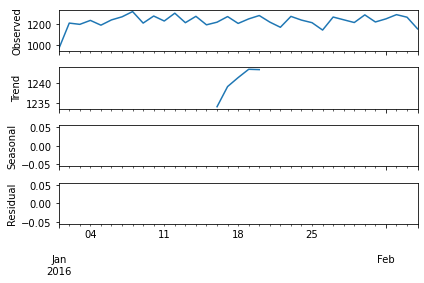

In [ ]:
#Seasonal decomposition is performed on the dataset to see if there is seasonality displayed in the per-day dataset at a frequency of 30 days(monthly)

result = seasonal_decompose(energy_per_day['use'], model='additive', freq=30)
result.plot()
plt.show()

**It is observed in the figure above that the per-day dataset displays a seasonal behavior at a frequency of 30**

**3. Stationarity**

In [ ]:
# split the dataset into two, and calculate mean and variance for both subsets

X = energy_data.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.117747, mean2=0.117860
variance1=0.156832, variance2=0.151133


**The dataset is splitted into two contiguous halves. Mean and variance is calculated for each subset. There is a little difference observed but it can be concluded that the values are essentially in the same ballpark.**

## Part 6 - Anomaly Detection


In [ ]:
data = energy_per_day.filter(items=['gen'])
df = data

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)

df['scores']=isolation_forest.decision_function(df[['gen']])
df['anomaly']=isolation_forest.predict(df[['gen']])
df.head(5)

,gen,scores,anomaly
2016-01-01,93.739450,-0.238464,-1
2016-01-02,110.368583,0.083478,1
2016-01-03,106.970133,0.025048,1
2016-01-04,109.579067,0.088173,1
2016-01-05,116.496617,-0.100711,-1


In [ ]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                   gen    scores  anomaly
2016-01-01   93.739450 -0.238464       -1
2016-01-05  116.496617 -0.100711       -1
2016-01-16  101.442133 -0.053326       -1
2016-01-18  114.221600 -0.000777       -1
2016-01-24  117.386817 -0.150200       -1
2016-01-25  114.976767 -0.001704       -1
2016-01-29  103.555617 -0.014336       -1
2016-01-30  101.719083 -0.036821       -1
2016-01-31  104.587633 -0.029143       -1
2016-02-01  102.872783 -0.033921       -1
2016-02-04   96.884400 -0.181004       -1


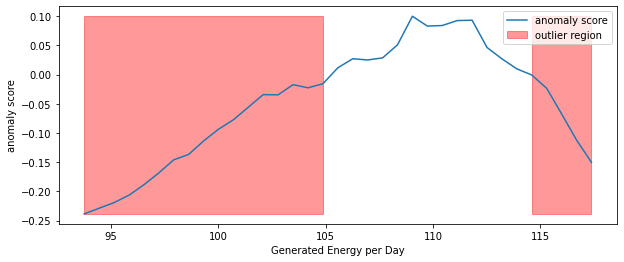

In [ ]:
# Distribution of generated energy per day
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generated Energy per Day')
plt.show();

In [ ]:
data = energy_per_week.filter(items=['gen'])
df = data

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)

df['scores']=isolation_forest.decision_function(df[['gen']])
df['anomaly']=isolation_forest.predict(df[['gen']])
df.head(5)

,gen,scores,anomaly
2016-01-03,311.078167,-0.138803,-1
2016-01-10,783.260817,0.067633,1
2016-01-17,754.365667,0.068739,1
2016-01-24,784.565567,0.059345,1
2016-01-31,756.925200,0.074226,1


In [ ]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                   gen    scores  anomaly
2016-01-03  311.078167 -0.138803       -1
2016-02-07  422.686817 -0.088541       -1


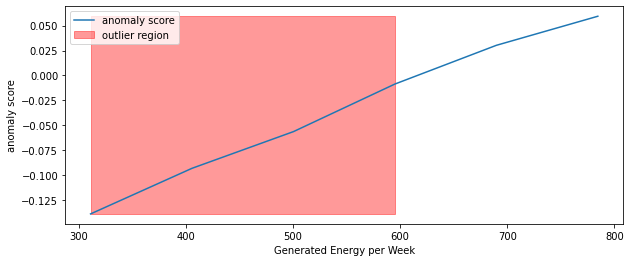

In [ ]:
# Distribution of generated energy per week
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generated Energy per Week')
plt.show();

In [ ]:
data = energy_per_month.filter(items=['gen'])
df = data

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)

df['scores']=isolation_forest.decision_function(df[['gen']])
df['anomaly']=isolation_forest.predict(df[['gen']])
df.head(5)

,gen,scores,anomaly
2016-01-31,3390.195417,0.0,1
2016-02-29,422.686817,0.0,1


In [ ]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

Empty DataFrame
Columns: [gen, scores, anomaly]
Index: []


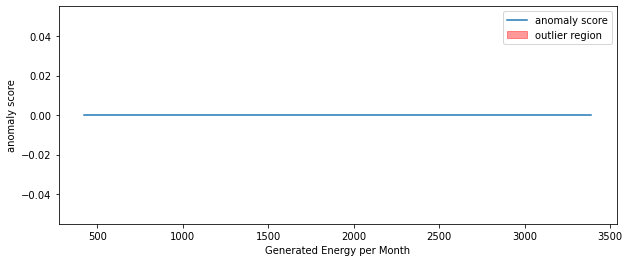

In [ ]:
# Distribution of generated energy per month
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generated Energy per Month')
plt.show();

In [ ]:
data = energy_per_day.filter(items=['use'])
df = data

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)

df['scores']=isolation_forest.decision_function(df[['use']])
df['anomaly']=isolation_forest.predict(df[['use']])
df.head(5)

,use,scores,anomaly
2016-01-01,964.110017,-0.324868,-1
2016-01-02,1212.072167,0.101377,1
2016-01-03,1200.051600,0.030158,1
2016-01-04,1237.830050,0.079467,1
2016-01-05,1192.251017,0.019878,1


In [ ]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                    use    scores  anomaly
2016-01-01   964.110017 -0.324868       -1
2016-01-08  1322.167317 -0.185698       -1
2016-01-12  1306.653833 -0.104300       -1
2016-01-22  1172.040717 -0.054729       -1
2016-01-26  1145.451333 -0.105788       -1
2016-02-02  1292.793450 -0.004658       -1
2016-02-04  1156.672467 -0.057135       -1


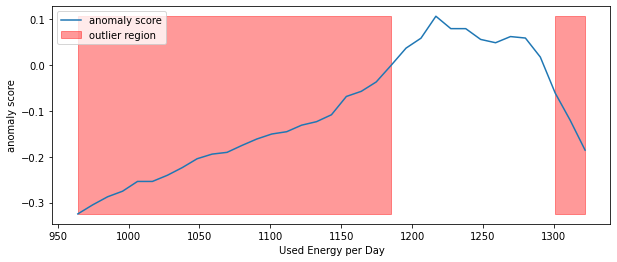

In [ ]:
# Distribution of use energy per day
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Used Energy per Day')
plt.show();

In [ ]:
data = energy_per_week.filter(items=['use'])
df = data

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)

df['scores']=isolation_forest.decision_function(df[['use']])
df['anomaly']=isolation_forest.predict(df[['use']])
df.head(5)

,use,scores,anomaly
2016-01-03,3376.233783,-0.140441,-1
2016-01-10,8758.604383,0.053276,1
2016-01-17,8721.878717,0.104813,1
2016-01-24,8655.709817,0.097665,1
2016-01-31,8605.770533,0.046600,1


In [ ]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                    use    scores  anomaly
2016-01-03  3376.233783 -0.140441       -1
2016-02-07  4970.202467 -0.091563       -1


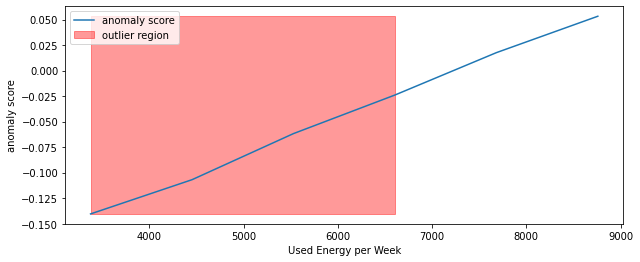

In [ ]:
# Distribution of use energy per week
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Used Energy per Week')
plt.show();

In [ ]:
data = energy_per_month.filter(items=['use'])
df = data

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(data.values.reshape(-1, 1))
xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)

df['scores']=isolation_forest.decision_function(df[['use']])
df['anomaly']=isolation_forest.predict(df[['use']])
df.head(5)

,use,scores,anomaly
2016-01-31,38118.197233,0.0,1
2016-02-29,4970.202467,0.0,1


In [ ]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

Empty DataFrame
Columns: [use, scores, anomaly]
Index: []


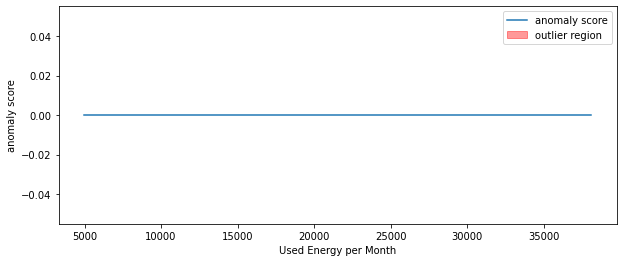

In [ ]:
# Distribution of use energy per month
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Used Energy per Month')
plt.show();

**Multivariate Anomaly Detection**

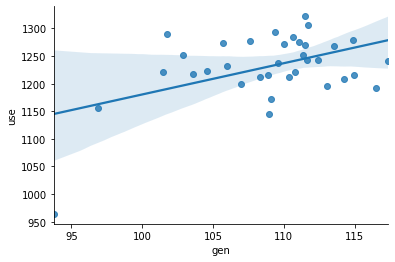

In [ ]:
# Generated vs Used Energy per day 
sns.regplot(x="gen", y="use", data=energy_per_day)
sns.despine();

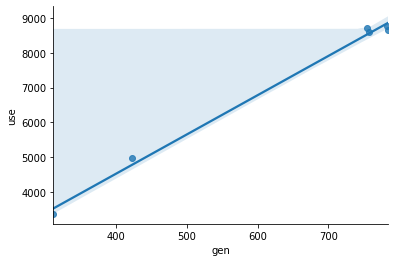

In [ ]:
# Generated vs Used Energy per week 
sns.regplot(x="gen", y="use", data=energy_per_week)
sns.despine();

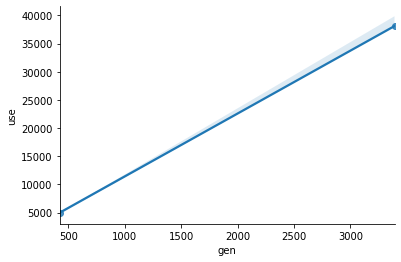

In [ ]:
# Generated vs Used Energy per month 
sns.regplot(x="gen", y="use", data=energy_per_month)
sns.despine();

####Moving Average

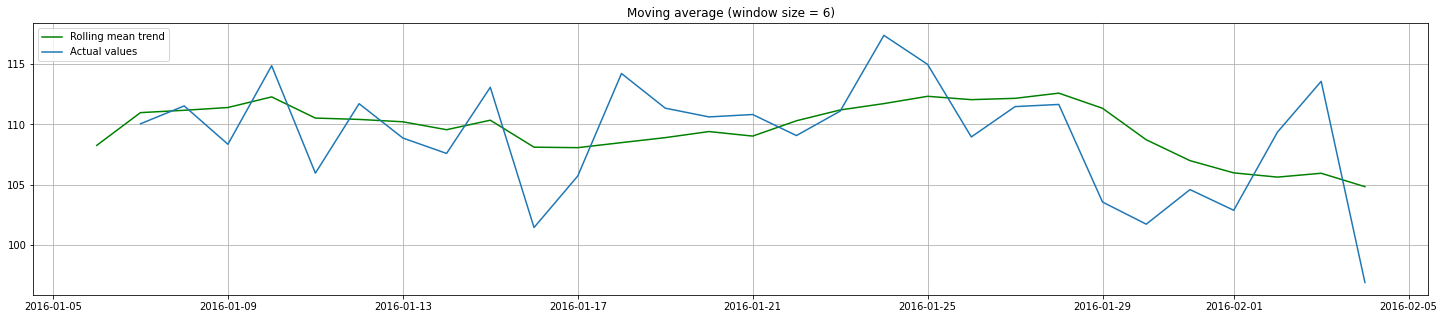

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
  rolling_mean = series.rolling(window=window).mean()

  plt.figure(figsize=(25,5))
  plt.title("Moving average (window size = {})".format(window))
  plt.plot(rolling_mean, "g", label="Rolling mean trend")

  # Plot confidence intervals for smoothed values
  if plot_intervals:
      mae = mean_absolute_error(series[window:], rolling_mean[window:])
      deviation = np.std(series[window:] - rolling_mean[window:])
      lower_bond = rolling_mean - (mae + scale * deviation)
      upper_bond = rolling_mean + (mae + scale * deviation)
      plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
      plt.plot(lower_bond, "r--")
      
      # Having the intervals, find abnormal values
      if plot_anomalies:
          anomalies = pd.DataFrame(index=series.index, columns=series.columns)
          anomalies[series<lower_bond] = series[series<lower_bond]
          anomalies[series>upper_bond] = series[series>upper_bond]
          plt.plot(anomalies, "ro", markersize=10)
      
  plt.plot(series[window:], label="Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)

n_samples = 24*30 # 1 month
data = energy_per_day.filter(items=['gen'])
plotMovingAverage(data[:n_samples], window=6) # A window of 6 hours

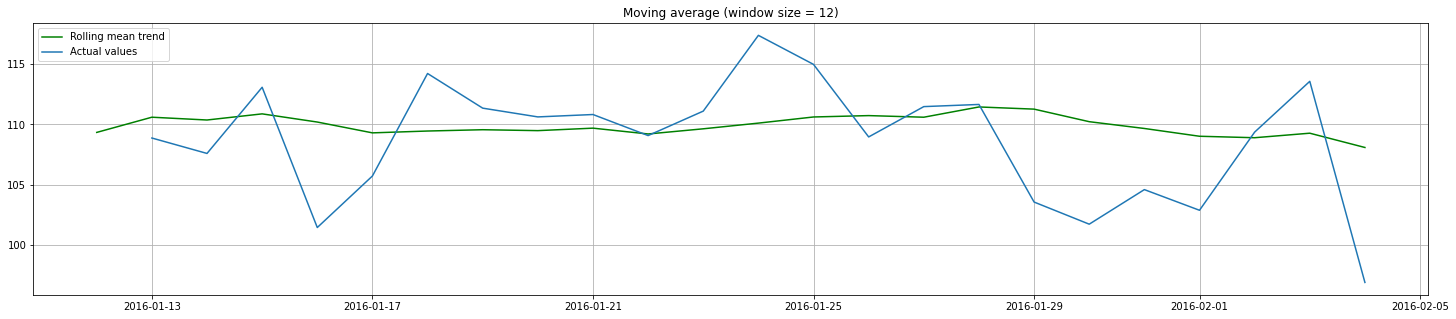

In [ ]:
plotMovingAverage(data[:n_samples], window=12) # A window of 12 hours

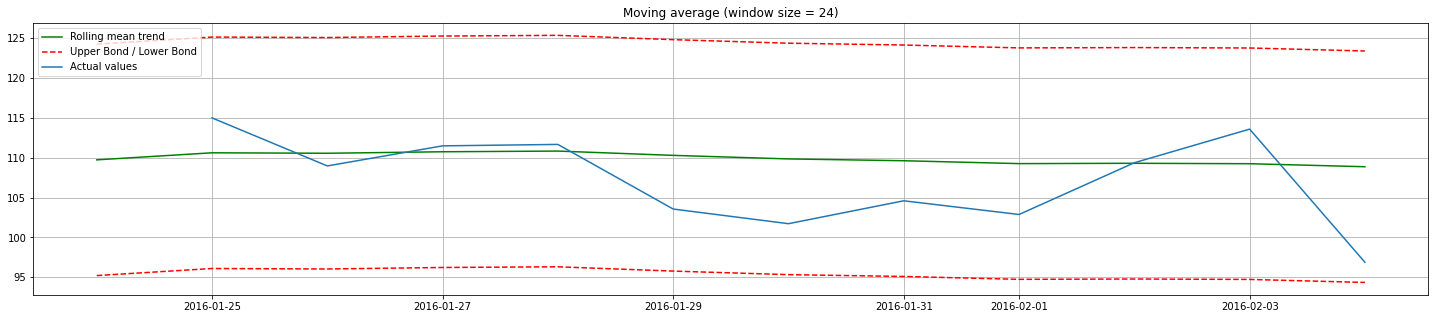

In [ ]:
plotMovingAverage(data[:n_samples], window=24, plot_intervals=True, plot_anomalies=True)

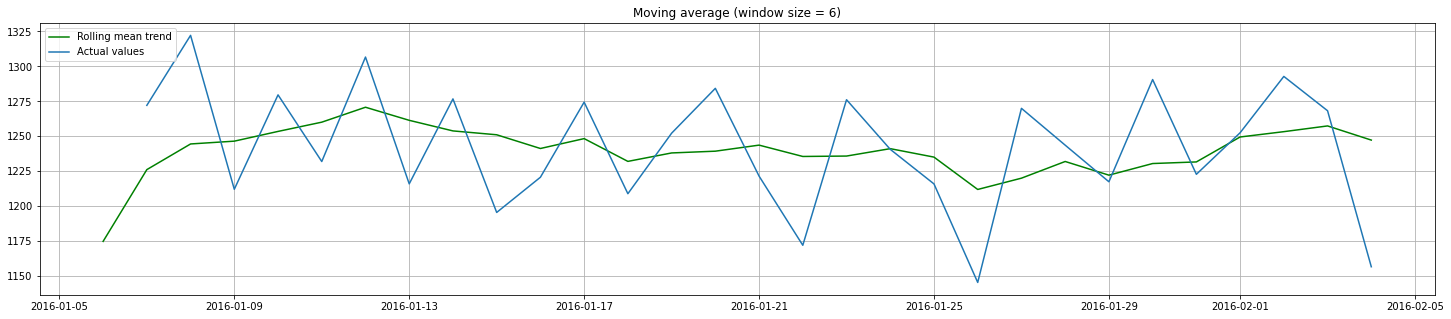

In [ ]:
data = energy_per_day.filter(items=['use'])
plotMovingAverage(data[:n_samples], window=6) # A window of 6 hours

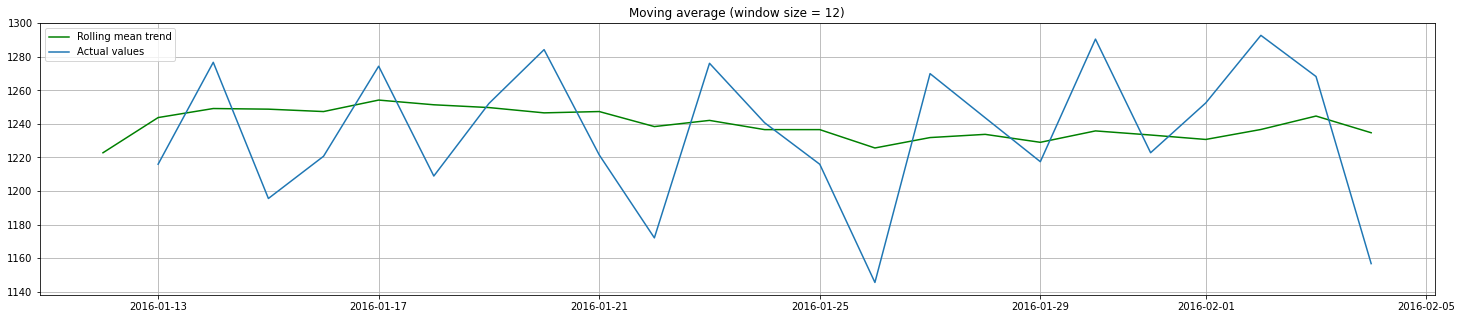

In [ ]:
plotMovingAverage(data[:n_samples], window=12) # A window of 12 hours

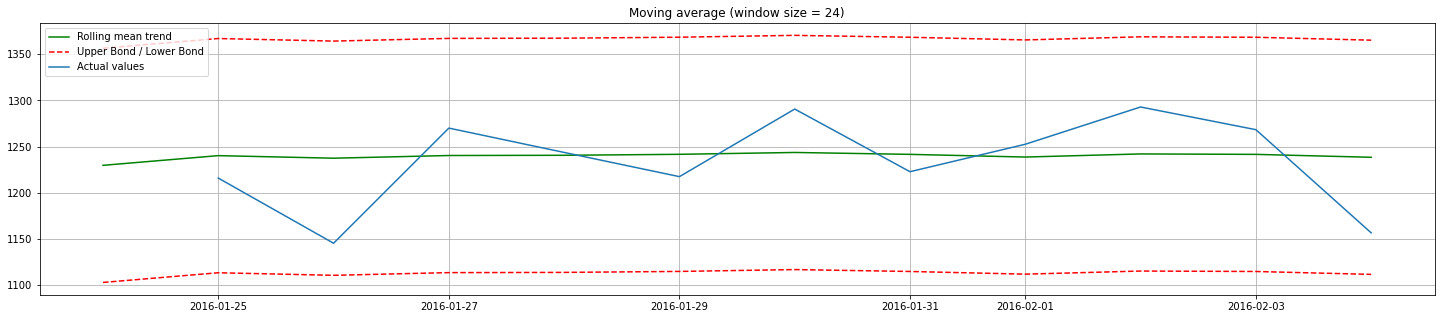

In [ ]:
plotMovingAverage(data[:n_samples], window=24, plot_intervals=True, plot_anomalies=True)

## Part 7 - Time Series Forecasting using ARIMA model

Autocorrelation for 'use' =  -0.031259276879052805


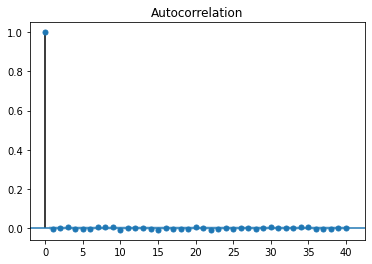

In [ ]:
#Autocorrelation plot is used to find the AR parameter p of the ARIMA model
print("Autocorrelation for 'use' = ", energy_per_day['use'].autocorr())
fig= plot_acf(energy_data['use'], lags=40)
plt.show()

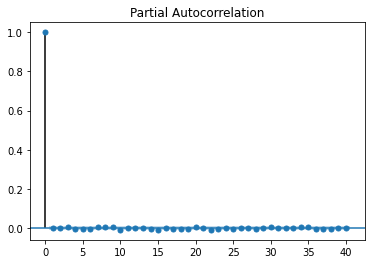

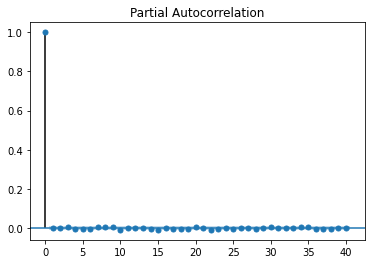

In [ ]:
plot_pacf(energy_data['use'], lags=40)

**PACF plot cuts of quickly after 5**

In [ ]:
#We initially trained the model on a resampled dataset with 20,000 records but since it takes a
#lot of time in the order of several hours depending on the p,d,q combinations of ARIMA we have 
#resampled the data with just 2000 records for the convenience of reducing the time of execution 

#Randomly selects the number of records passes to the attribute n
home_arima_df= home_df[0:2000]

**We experimented with different p and q values keeping d=1 for the ARIMA model and found that we get the best results with p=5, d=1 and q=0. Keeping the value q=1 or 2 was taking too long to train the data(more than two hours) with 20,000 records where as with q=0 we were able to train the model just under one hour(3571.43seconds) as indicated in the screenshot.**

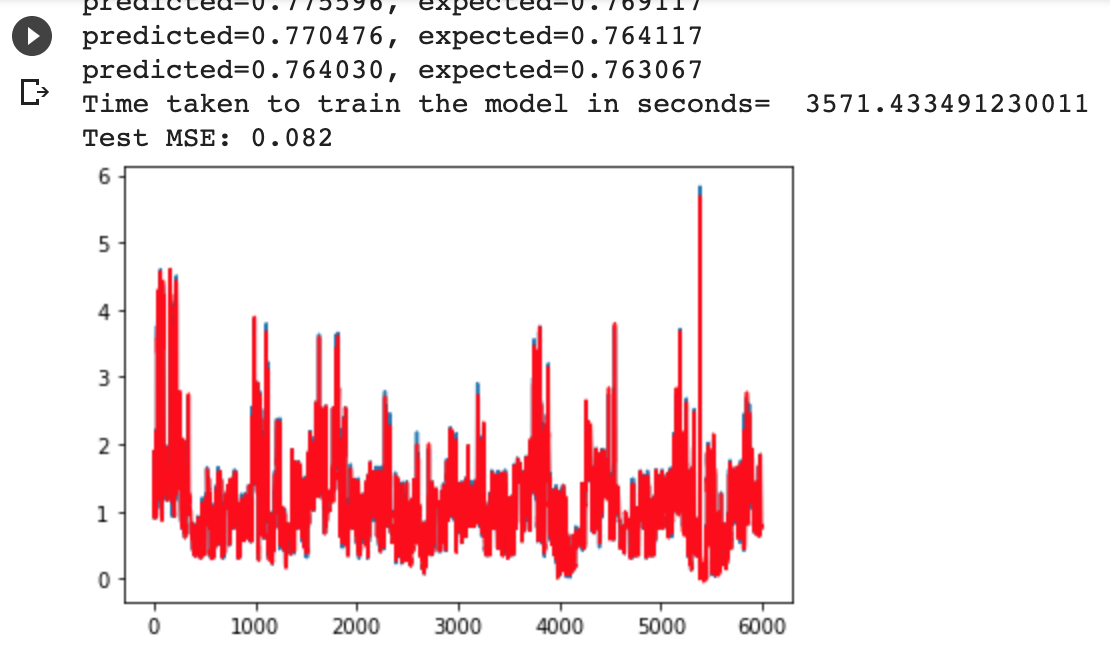

**Training an ARIMA model**

In [ ]:
#Trained on the the parameter values p=5, d=1 and q=0
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import time
 
X = home_arima_df['use'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
start_time= time.time()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
end_time= time.time()
time_taken= end_time-start_time
print('Time taken to train the model in seconds= ',time_taken)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=2.734013, expected=4.043967
predicted=1.496707, expected=0.492883
predicted=1.240134, expected=0.164967
predicted=1.337350, expected=0.336217
predicted=1.278652, expected=0.459017
predicted=1.046372, expected=0.391500
predicted=1.067122, expected=0.305683
predicted=0.352950, expected=3.202950
predicted=0.835561, expected=2.116467
predicted=1.028769, expected=0.563867
predicted=1.056560, expected=0.727250
predicted=1.241724, expected=0.224850
predicted=1.210061, expected=0.510333
predicted=1.307007, expected=0.679850
predicted=0.850689, expected=0.988267
predicted=0.607919, expected=0.706950
predicted=0.619564, expected=0.834617
predicted=0.638873, expected=0.772583
predicted=0.741053, expected=1.919417
predicted=0.992488, expected=1.327267
predicted=1.051887, expected=6.771400
predicted=2.097165, expected=0.586533
predicted=1.802720, expected=0.287867
predicted=1.874018, expected=0.028133
predicted=1.985304, expected=0.668000
predicted=1.688296, expected=0.598417
predicted=1.

**Residual Analysis of the ARIMA model**

In [ ]:
from pandas import DataFrame
#We get the information if the model is accurate from the residual analysis
residuals= DataFrame(model_fit.resid)
residuals.plot()

**There is no visible trend or pattern in the residuals plot which indicates our model is accurate**

In [ ]:
residuals.describe()

**The mean is centered around zero which indicates our model is accurate**

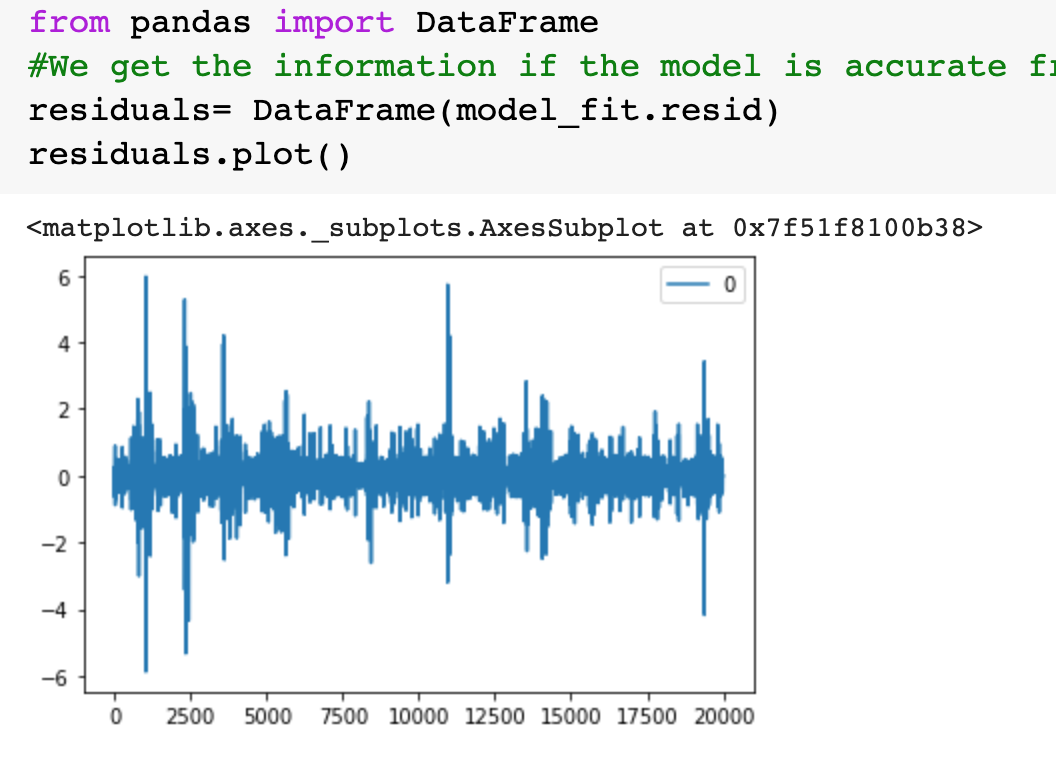

**Above is the residual plot for the model trained on 20,000 records with the parameter values p=5, d=1 and q=0. It clearly indicates there is no visible trend or pattern in the plot and hence no correlation between the residuals which indicates our model is accurate.**

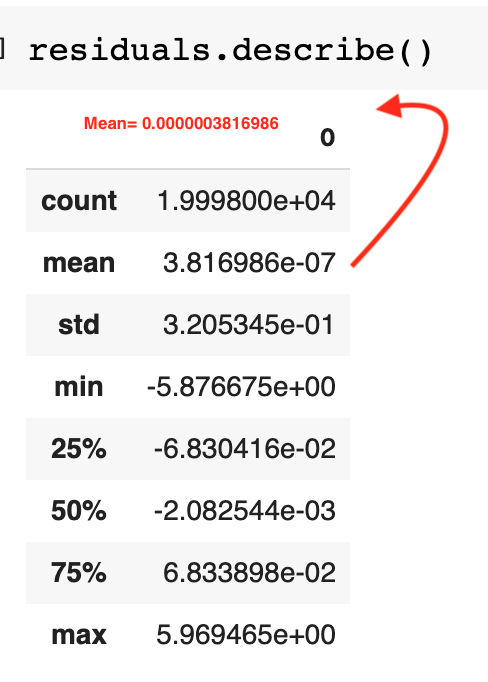

**The mean of the residuals is centered around 0 (3.816986e-07 = 0.0000003816986) for the model trained on 20,000 records which indicates our model is accurate**